# Player Keypoint Detection

The aim of this notebook is to test out the component of my application that detects the pose of the basketball player. We can easily detect pose by using Detectron2's pre-trained keypoint models that locate a player's head, shoulders, elbows, hands, knees, feet etc.

The primary objective of this notebook is to create a pipeline where I feed Detectron2 a video and it ouputs an annotated video of all player keypoints.

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.1 False


In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [28]:
# import some common libraries
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
import os
import tqdm

# 1. Read an Image

The first thing to do is to read an image into a format Detectron2's keypoint detection model accepts.



In [16]:
img = cv2.imread('../data/notebook_test_data/test1.jpg')

In [17]:
def plt_img(img):
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (15,8))
    plt.imshow(im)
    plt.xticks([]), plt.yticks([])
    plt.show()

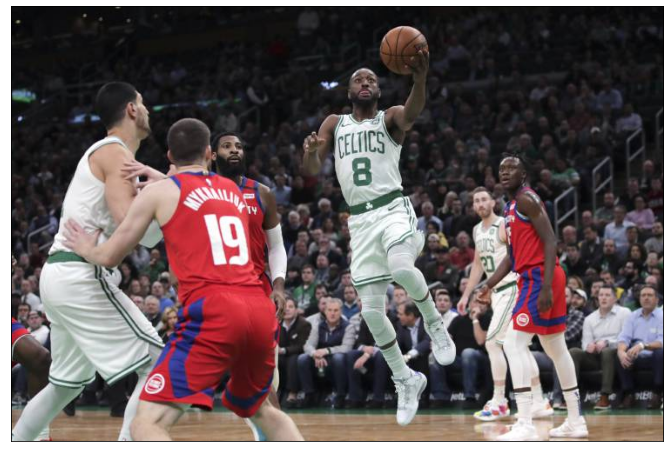

In [18]:
plt_img(img)

# 2. Plug Image into Detectron2 Model

Plug the image into a pretrained Detectron2 keypoint model.

The input formats that pre-trained Detectron2 models accept is listed here: \
https://detectron2.readthedocs.io/tutorials/models.html#model-input-format


## 2.1 Configure the Model to be Keypoint Detection Model

In [36]:
cfg = get_cfg()

# mac's do not have CUDA support, run on CPU
cfg.MODEL.DEVICE = "cpu"

# get pretrained model
config_file = "COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))

# model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)

# set some model specific hyperparameters
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # only post-process ROI heads with score > value


## 2.2 Run Keypoint Predictions

In [37]:
kp_detector = DefaultPredictor(cfg)
outputs = kp_detector(img)

model_final_721ade.pkl: 136MB [00:12, 10.7MB/s]                              


## 2.3 Visualize the Keypoint Predictions

In [38]:
outputs["instances"].pred_keypoints[0:2]

AttributeError: Cannot find field 'pred_keypoints' in the given Instances!

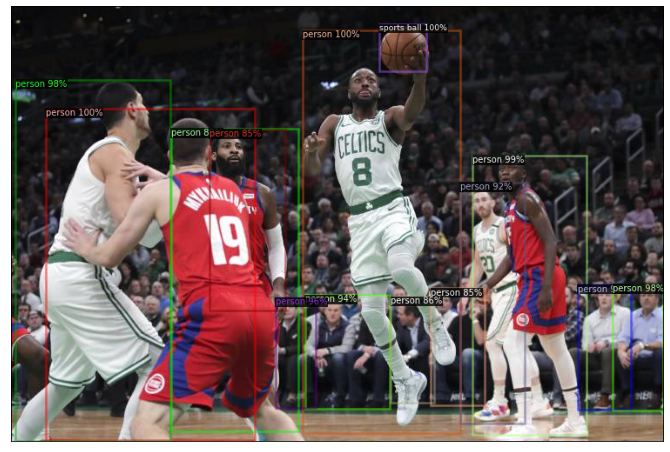

In [39]:
# convert from openCV BGR format to RGB format
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize = (15,8))
plt.xticks([]), plt.yticks([])
plt.imshow(out.get_image())

# 3. Plug Video into Detectron2 Model 

https://stackoverflow.com/questions/60663073/how-can-i-properly-run-detectron2-on-videos

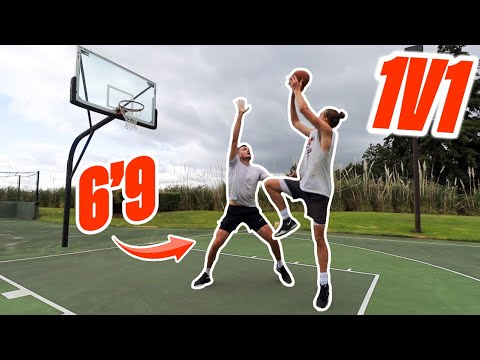

In [40]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("aB4-Ah0DWsc", width=500)
display(video)

In [41]:
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer

In [42]:
video_path = "../data/notebook_test_data/test2.mp4"

video      = cv2.VideoCapture(video_path)
width      = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height     = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps        = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
basename   = os.path.basename(video_path)

In [25]:
video_writer = cv2.VideoWriter('out.mp4',
                               fourcc = cv2.VideoWriter_fourcc(*"MP4V"),
                               fps = float(fps),
                               frameSize = (width, height),
                               isColor = True)

In [26]:
def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """

    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield visualization

        readFrames += 1
        if readFrames > maxFrames:
            break

In [29]:
v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)
predictor = kp_detector

# Create a cut-off for debugging
num_frames = 120

# Enumerate the frames of the video
for visualization in tqdm.tqdm(runOnVideo(video, num_frames), total=num_frames):

    # Write test image
    cv2.imwrite('POSE detectron2.png', visualization)

    # Write to video file
    video_writer.write(visualization)


121it [15:48,  7.84s/it]                         


In [30]:
# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()